<a href="https://colab.research.google.com/github/Lemonnik/BI_2021_JB_benchmark/blob/main/building_own_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import trange
import warnings

In [ ]:
# rdkit
!pip install rdkit-pypi
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# deepchem
!pip install deepchem
import deepchem as dc
from deepchem.models import GCNModel

     |████████████████████████████████| 22.3 MB 1.4 MB/s 
     |████████████████████████████████| 608 kB 4.8 MB/s 


In [ ]:
!pip install dgl
!pip install dgllife
!pip install torch-geometric
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html    # долго грузится, нужен для запуска собранной вручную модели
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html   # 

import torch
from torch.nn import Linear
# from torch_geometric import data
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

ModuleNotFoundError: ignored

# Импорт датасетов

The source data and data folds in the three sample scenarios used in this study are provided on the Zenodo at https://zenodo.org/record/5500305. The source data of the four benchmarks (the Luo’s dataset, Hetionet, the Yamanishi_08’s dataset and BioKG) is available on the https://github.com/luoyunan/DTINet, https://het.io/about/, https://drugtargets.insight-centre.org/, https://github.com/dsi-bdi/biokg, respectively. Source data are provided with this paper.


From https://www.nature.com/articles/s41467-021-27137-3#MOESM1

Структура датасета:

* Uniprot ID $-$
* Target sequence $-$ белковая последовательность
* Drug ID $-$ DrugBank ID
* SMILES $-$ ASCII формула соединения в специальном формате
* Label $-$ есть ли взаимодействие

In [ ]:
# data = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv')
# data.head()

$~$

### Yamanishi

Stored at https://github.com/luoyunan/DTINet

<br>

`drug.txt`: list of drug names <br>
`protein.txt`: list of protein names <br>
`mat_protein_drug.txt`: Protein-Drug interaction matrix <br>


In [ ]:
import requests
import time
from tqdm.notebook import tqdm


# for proteins
!pip install biopython
from Bio import SeqIO
from io import StringIO

# for drugs (CID --> smiles)
!pip install pubchempy
import pubchempy as pcp

In [ ]:
def parse_uniprot(uniprot_ids):
    '''
    UniProt IDs --> [(ID, sequence), ...] array
    '''

    baseUrl = 'https://www.uniprot.org/uniprot/'

    protein_to_pdb = []

    for protein in tqdm(uniprot_ids, total=len(uniprot_ids)):
        currentUrl = baseUrl + protein + ".fasta"
        response = requests.post(currentUrl)
        cData = ''.join(response.text)

        Seq = StringIO(cData)
        pSeq=list(SeqIO.parse(Seq,'fasta'))
        if pSeq:
            # protein_to_pdb[protein] = str(pSeq[0].seq)
            protein_to_pdb.append((protein, str(pSeq[0].seq)))
        else:
            print(f"Unable to read protein {protein}. Sequence will be replaced with '{float('nan')}'")
            # protein_to_pdb[protein] = float('nan')
            protein_to_pdb.append((protein, float('nan')))

        time.sleep(0.001)  # be respectful and don't overwhelm the server with requests

    return protein_to_pdb

In [ ]:
from math import nan
# read https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest

# P.S. Берём каноническую изоформу, а есть ещё isomeric


def parse_drugbank(drugbank_ids):
    '''
    DrugBank IDs --> [(DrugBank ID, SMILES), ...] array
    '''

    url1 = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/drugbank/'
    url3 = '/json'

    n_drugs = len(drugbank_ids)

    smiles = []

    for drug in tqdm(drugbank_ids, total=n_drugs):
        # DrugBank ID --> PubChem Compound ID (CID)
        response = requests.get(url1+drug+url3)
        try:
            cid = response.json()['PC_Substances'][0]['compound'][1]['id']['id']['cid']
        except:
            print(f"Some problems with drug {drug} on stage \'DrugBankID --> CID\'. Creating ({drug},{float('NaN')}) pair.")
            smiles.append((drug, float('NaN')))
            continue

        # CID --> {CID: SMILES} dict
        try:
            s = pcp.Compound.from_cid(cid).canonical_smiles
            smiles.append((drug, s))
        except:
            print(f"Some problems with drug {drug} on stage \'CID --> SMILES\'. Creating ({drug},{float('NaN')}) pair.")
            smiles.append((drug, float('NaN')))
            continue

        # little pause
        time.sleep(0.001)

    return smiles

In [ ]:
def load_yamanishi(n_proteins=-1):
    folder = 'https://raw.githubusercontent.com/luoyunan/DTINet/master/data/'

    # get SMILES
    print('Loading drugs...')
    response_d = requests.get(folder + 'drug.txt')
    yamanishi_drug_ids = response_d.text.split()
    yamanishi_drug_smiles = parse_drugbank(yamanishi_drug_ids)
    print('That\'s all with drugs\n')

    # get protein sequences
    print('Loading proteins...')
    response_p = requests.get(folder + 'protein.txt')
    yamanishi_prot_ids = response_p.text.split()
    yamanishi_prot_seqs = parse_uniprot(yamanishi_prot_ids[:n_proteins])  # ограничение на белки n_proteins
    print('That\'s all with proteins\n')

    # get drug-target protein interaction info
    print('Loading DTI matrix...')
    response_dti = requests.get(folder + 'mat_protein_drug.txt')
    yamanishi_dti = response_dti.text.strip()
    yamanishi_dti = [int(row) for row in yamanishi_dti if row in ['0', '1']]  # делаем один длинный массив из 0 и 1
    print('Matrix donwloaded, creating final dataset...\n')


    # чтобы не бежать по всем значениям мы как бы умножаем массив на нужное число взаимодействий
    # то есть если у нас 2 белка и 3 лекарства,
    #    то вместо белков   ['prot1', 'prot2']           станет   ['prot1', 'prot1', 'prot1', 'prot2', 'prot2', 'prot2'] 
    #    а вместо лекарств  ['drug1', 'drug2', 'drug3']  станет   ['drug1', 'drug2', 'drug3', 'drug1', 'drug2', 'drug3']
    #    и в итоге получим нужные взаимодействия

    # ПРОБЛЕМА: если качать втупую, то получаются слишком большие датафрэймы в памяти

    df = pd.DataFrame({"Uniprot ID": np.concatenate([([p[0]]*len(yamanishi_drug_smiles)) for p in yamanishi_prot_seqs], axis=0),
                       "Target sequence": np.concatenate([([p[1]]*len(yamanishi_drug_smiles)) for p in yamanishi_prot_seqs], axis=0),
                       "Drug ID": [d[0] for d in yamanishi_drug_smiles] * len(yamanishi_prot_seqs),
                       "SMILES": [d[1] for d in yamanishi_drug_smiles] * len(yamanishi_prot_seqs),
                       "Label": yamanishi_dti[:len(yamanishi_drug_smiles)*len(yamanishi_prot_seqs)]}  # ограничение на белки n_proteins
                      )


    print('Finished!')

    return df

Loading DTI matrix...
Matrix donwloaded, creating final dataset...

Finished!


In [ ]:
load_yamanishi(2)  # загрузит 2 первых белка. Чисто посмотреть что работает

,Uniprot ID,Target sequence,Drug ID,SMILES,Label
0,Q9UI32,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,DB00050,CC(C)CC(C(=O)NC(CCCN=C(N)N)C(=O)N1CCCC1C(=O)NC...,0
1,Q9UI32,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,DB00152,CC1=C(SC=[N+]1CC2=CN=C(N=C2N)C)CCO,0
2,Q9UI32,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,DB00162,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CCO)C)C,0
3,Q9UI32,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,DB00175,NaN,0
4,Q9UI32,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,DB00176,COCCCCC(=NOCCN)C1=CC=C(C=C1)C(F)(F)F,0
...,...,...,...,...,...
1411,P00488,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,DB06711,C1CN=C(N1)CC2=CC=CC3=CC=CC=C32,0
1412,P00488,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,DB06800,C[N+]1(CCC23C4C(=O)CCC2(C1CC5=C3C(=C(C=C5)O)O4...,0
1413,P00488,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,DB06811,CCCCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO,0
1414,P00488,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,DB08826,CC1=C(C(=O)C=CN1C)O,0


In [ ]:
print('Всего взаимодействий:', 1512*708)  # число белков на число молекул

Всего взаимодействий: 1070496


In [ ]:
# yamanishi_dpi2 = [yamanishi_dpi[i].split(' ') for i in range(len(yamanishi_dpi))]

In [ ]:
# len(yamanishi_dpi2[0]), len(yamanishi_dpi2)

(708, 1512)

### DAVIS & BindingDB

Can be taken from https://github.com/kexinhuang12345/MolTrans/tree/master/dataset



In [ ]:
# all from https://github.com/kexinhuang12345/MolTrans/tree/master/dataset

dataFolder = 'https://raw.githubusercontent.com/kexinhuang12345/MolTrans/master/dataset/DAVIS/'        # DAVIS
# dataFolder = 'https://raw.githubusercontent.com/kexinhuang12345/MolTrans/master/dataset/BindingDB/'  # BindingDB


# TODO: Luo, Yamanishi, ...

In [ ]:
davis_train = pd.read_csv(dataFolder + '/train.csv', index_col=0)
davis_test = pd.read_csv(dataFolder + '/test.csv', index_col=0)
davis_val = pd.read_csv(dataFolder + '/val.csv', index_col=0)


# TODO: не знаю по какому принципу они в той статье делили исходный на 3 части
#       поэтому может лучше взять большой и уже потом самостоятельно его делить

In [ ]:
davis_train.Label.values

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
davis_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3006 entries, 0 to 3005
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SMILES           3006 non-null   object
 1   Target Sequence  3006 non-null   object
 2   Label            3006 non-null   int64 
 3   drug_encoding    3006 non-null   object
 4   target_encoding  3006 non-null   object
dtypes: int64(1), object(4)
memory usage: 140.9+ KB


In [ ]:
davis_train.head()

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MLKFKYGARNPLDAGAAEPIASRASRLNLFFQGKPPFMTQQQMSPL...,1,[0. 1. 0. ... 0. 0. 0.],[7.499 6.66 3.552 ... 0. 0. 0. ]
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MRHSKRTYCPDWDDKDWDYGKWRSSSSHKRRKRSHSSAQENKRCKY...,1,[0. 1. 0. ... 0. 0. 0.],[3.306 9.091 2.893 ... 0. 0. 0. ]
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MRHSKRTHCPDWDSRESWGHESYRGSHKRKRRSHSSTQENRHCKPH...,1,[0. 1. 0. ... 0. 0. 0.],[ 2.703 10.187 2.911 ... 0. 0. 0. ]
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MAPFLRIAFNSYELGSLQAEDEANQPFCAVKMKEALSTERGKTLVQ...,1,[0. 1. 0. ... 0. 0. 0.],[5.769 4.882 4.29 ... 0. 0. 0. ]
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MVVFNGLLKIKICEAVSLKPTAWSLRHAVGPRPQTFLLDPYIALNV...,1,[0. 1. 0. ... 0. 0. 0.],[5.834 5.834 3.799 ... 0. 0. 0. ]


In [ ]:
len(davis_val['Target Sequence'].unique()), len(davis_train['Target Sequence'].unique()), len(davis_test['Target Sequence'].unique()), 

(378, 372, 379)

In [ ]:
len(davis_val['SMILES'].unique()), len(davis_train['SMILES'].unique()), len(davis_test['SMILES'].unique()), 

(68, 68, 68)

### RANDOM METHOD

In [ ]:
# лучше задавать значение по умолчанию, когда будешь писать класс/функцию

# https://github.com/bmd2007/benchmark_eval/blob/aa42bb3369e79db4cb63e1963afcc8af6d8f5696/PPIPUtils.py#L354

import random

seed = 42

random.seed(seed)
np.random.seed(seed)

In [ ]:
# запоминаем 1 и 0 индексы в датасете (строки датафрэйма)

pos = davis_train.loc[davis_train.Label == 1, :]
neg = davis_train.loc[davis_train.Label == 0, :]

In [ ]:
def shuffle_indexes(pos, neg, k, seed=1):
    # shuffle all indexes
    posIdx = [x for x in range(0,len(pos))]
    negIdx = [x for x in range(0,len(neg))]

    random.shuffle(posIdx)
    random.shuffle(negIdx)

    pos = np.asarray(pos)
    neg = np.asarray(neg)


    # get K folds
    trainSplits = []
    testSplits = []
    for i in range(0,k):
        startP = int((i/k)*pos.shape[0])
        endP = int(((i+1)/k)* pos.shape[0])
        startN = int((i/k)*neg.shape[0])
        endN = int(((i+1)/k)* neg.shape[0])
        if i == k-1:
            endP = pos.shape[0]
            endN = neg.shape[0]
        a = pos[posIdx[:startP],:]
        b = pos[posIdx[endP:],:]
        c = neg[negIdx[:startN],:]
        d = neg[negIdx[endN:],:]
        lst = np.vstack((a,b,c,d))
        np.random.shuffle(lst)
        trainSplits.append(lst)

        e = pos[posIdx[startP:endP],:]
        f = neg[negIdx[startN:endN],:]
        lst = np.vstack((e,f))
        np.random.shuffle(lst)
        testSplits.append(lst)

    
    return trainSplits, testSplits

In [ ]:
def createKFolds(data, k, seed=1):
    '''
    Делает k фолдов train-validation
    '''
    pos = data.loc[data.Label == 1, :]
    neg = data.loc[data.Label == 0, :]
    return shuffle_indexes(pos, neg, k, seed=seed)

In [ ]:
tr, val = createKFolds(davis_train, 5)

In [ ]:
print('размеры train фолдов:', [len(fold) for fold in tr])
print('размеры valid фолдов:', [len(fold) for fold in val])

размеры train фолдов: [1670, 1668, 1670, 1668, 1668]
размеры valid фолдов: [416, 418, 416, 418, 418]


$~$

### COLD PROTEIN METHOD

In [ ]:
HeldOutProt = 0.1  # какой % белков удержать от появления в тренировочном датасете, чтобы были только в тестовом

In [ ]:
# задаём число белков, которые войдут в трэин/вал датасет

n_prot = int(len(davis_train['Target Sequence'].unique()) * (1 - HeldOutProt))

print('Белков пойдёт в train:', n_prot)

Белков пойдёт в train: 334


In [ ]:
# выбираем уникальные белки, перемешиваем их, отбираем нужную часть

protein_list = davis_train['Target Sequence'].unique()
print('Первый белок:', protein_list[0][:15], '...')

Первый белок: MLKFKYGARNPLDAG ...


In [ ]:
random.shuffle(protein_list)
print('Всего белков:', len(protein_list))
print('Первый белок:', protein_list[0][:15], '...')

Всего белков: 372
Первый белок: MTVFRQENVDDYYDT ...


In [ ]:
# запоминаем белки, которые должны войти в тренировочный и тестовый датасеты

protein_train = protein_list[:n_prot]
protein_test = protein_list[n_prot:]

print('Белков пошло в train:', len(protein_train))
print('Белков пошло в test:', len(protein_test))

Белков пошло в train: 334
Белков пошло в test: 38


In [ ]:
# отбираем нужные белки из датафрэйма

train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for i in range(len(davis_train)):
    line = davis_train.iloc[i,:]

    # предполагая, что в датасете Target Sequence на 2-ой позиции
    # МАГИЧЕСКОЕ ЧИСЛО, ИСПРАВИТЬ
    if line.to_list()[1] in protein_train:
        train_dataset = train_dataset.append(line)
    else:
        test_dataset = test_dataset.append(line)

In [ ]:
print('Записей из исходного датафрэйма пошло в train:', len(train_dataset))
print('Записей из исходного датафрэйма пошло в test:', len(test_dataset))

Записей из исходного датафрэйма пошло в train: 1788
Записей из исходного датафрэйма пошло в test: 298


In [ ]:
# с балансом классов всё ок
# но наверное надо как-то контролировать этот момент??
# и нужен ли вообще этот баланс

print('Для train:')
print('После отбора 10% в валидацию, с меткой 1 =', len(train_dataset.loc[train_dataset.Label == 1, :]))
print('После отбора 10% в валидацию, с меткой 0 =', len(train_dataset.loc[train_dataset.Label == 0, :]))

print('\nДля test:')
print('После отбора 10% в валидацию, с меткой 1 =', len(test_dataset.loc[test_dataset.Label == 1, :]))
print('После отбора 10% в валидацию, с меткой 0 =', len(test_dataset.loc[test_dataset.Label == 0, :]))

Для train:
После отбора 10% в валидацию, с меткой 1 = 875
После отбора 10% в валидацию, с меткой 0 = 913

Для test:
После отбора 10% в валидацию, с меткой 1 = 168
После отбора 10% в валидацию, с меткой 0 = 130


In [ ]:
# теперь на тестовую часть можно применить функцию выше, чтобы разделить train --> train+valid фолды

In [ ]:
tr, val = createKFolds(train_dataset, k=5)

In [ ]:
print('размеры train фолдов:', [len(fold) for fold in tr])
print('размеры valid фолдов:', [len(fold) for fold in val])

размеры train фолдов: [1431, 1430, 1431, 1430, 1430]
размеры valid фолдов: [357, 358, 357, 358, 358]


$~$

### COLD DRUG METHOD

In [ ]:
HeldOutDrug = 0.1  # какой % лекарств удержать от появления в тренировочном датасете, чтобы были только в тестовом

In [ ]:
# задаём число лекарств, которые войдут в трэин/вал датасет

n_drug = int(len(davis_train['SMILES'].unique()) * (1 - HeldOutDrug))
print('Лекарств пойдёт в train:', n_drug)

Лекарств пойдёт в train: 61


In [ ]:
# выбираем уникальные лекарства, перемешиваем их, отбираем нужную часть

drug_list = davis_train['SMILES'].unique()
print('Первый drug:', drug_list[0])

Первое drug: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N


In [ ]:
random.shuffle(drug_list)
print('Всего drugs:', len(drug_list))
print('Первый drug:', drug_list[0])

Всего drugs: 68
Первый drug: CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O)NC)OC


In [ ]:
# запоминаем лекарства, которые должны войти в тренировочный датасет

drug_train = drug_list[:n_drug]
drug_test = drug_list[n_drug:]

print('Drugs пошло в train:', len(drug_train))
print('Drugs пошло в test:', len(drug_test))

Drugs пошло в train: 61
Drugs пошло в test: 7


In [ ]:
# отбираем нужные лекарства из датафрэйма

train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for i in range(len(davis_train)):
    line = davis_train.iloc[i,:]

    # предполагая, что в датасете SMILES на 1-ой позиции
    # МАГИЧЕСКОЕ ЧИСЛО, ИСПРАВИТЬ
    if line.to_list()[0] in drug_train:
        train_dataset = train_dataset.append(line)
    else:
        test_dataset = test_dataset.append(line)

In [ ]:
print('Записей из исходного датафрэйма пошло в train:', len(train_dataset))
print('Записей из исходного датафрэйма пошло в test:', len(test_dataset))

Записей из исходного датафрэйма пошло в train: 1873
Записей из исходного датафрэйма пошло в test: 213


In [ ]:
# с балансом классов всё ок
# но наверное надо как-то контролировать этот момент??
# и нужен ли вообще этот баланс

print('Для train:')
print('После отбора 10% в валидацию, с меткой 1 =', len(train_dataset.loc[train_dataset.Label == 1, :]))
print('После отбора 10% в валидацию, с меткой 0 =', len(train_dataset.loc[train_dataset.Label == 0, :]))

print('\nДля test:')
print('После отбора 10% в валидацию, с меткой 1 =', len(test_dataset.loc[test_dataset.Label == 1, :]))
print('После отбора 10% в валидацию, с меткой 0 =', len(test_dataset.loc[test_dataset.Label == 0, :]))

Для train:
После отбора 10% в валидацию, с меткой 1 = 936
После отбора 10% в валидацию, с меткой 0 = 937

Для test:
После отбора 10% в валидацию, с меткой 1 = 107
После отбора 10% в валидацию, с меткой 0 = 106


In [ ]:
# опять же, полученный train датасет можем делить на фолды

tr, val = createKFolds(train_dataset, k=5)
print('размеры train фолдов:', [len(fold) for fold in tr])
print('размеры valid фолдов:', [len(fold) for fold in val])

размеры train фолдов: [1499, 1499, 1498, 1499, 1497]
размеры valid фолдов: [374, 374, 375, 374, 376]


# Модель из статьи

In [ ]:
# что-то для себя
# https://github.com/bmd2007/benchmark_eval/blob/main/RunTrainTest.py
# https://github.com/bmd2007/benchmark_eval/blob/aa42bb3369e79db4cb63e1963afcc8af6d8f5696/ProjectDataLoader.py

In [ ]:
# https://github.com/kexinhuang12345/DeepPurpose  -- откуда взята модель

!pip install git+https://github.com/bp-kelley/descriptastorus 
!pip install DeepPurpose

  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-u69x1el8
  Running command git clone -q https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-u69x1el8


In [ ]:
from DeepPurpose import DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *

### Деление данных

In [ ]:
# Load Data, an array of SMILES for drug, an array of Amino Acid Sequence for Target and an array of binding values/0-1 label.
# e.g. ['Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1', ...], ['MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTH...', ...], [0.46, 0.49, ...]
# In this example, BindingDB with Kd binding score is used.

# пример из статьи
# X_drug, X_target, y  = process_BindingDB(download_BindingDB(SAVE_PATH),
#                                          y = 'Kd', 
#                                          binary = False, 
#                                          convert_to_log = True)

X_drug, X_target, y  = davis_train['SMILES'].to_list(), davis_train['Target Sequence'].to_list(), davis_train['Label'].to_list()

$~$

У них там встроенные cold start доступны, код может быть полезен!<br>
Но можно и свои подать.

In [ ]:
# Type in the encoding names for drug/protein.
drug_encoding, target_encoding = 'CNN', 'Transformer'

# Data processing, here we select cold protein split setup.
train, val, test = data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='cold_protein', 
                                frac=[0.7,0.1,0.2])

Drug Target Interaction Prediction Mode...
in total: 2086 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 372
splitting dataset...
Done.


$~$

### Обучение (вернее взятие готовой модели)

Возьмём уже готовую модель, так как обучение колаб не тянет по переполнению RAM

In [ ]:
# # Generate new model using default parameters; also allow model tuning via input parameters.
# config = generate_config(drug_encoding, target_encoding, transformer_n_layer_target = 8)
# net = models.model_initialize(**config)

# # Train the new model.
# # Detailed output including a tidy table storing validation loss, metrics, AUC curves figures and etc. are stored in the ./result folder.
# net.train(train, val, test)

In [ ]:
from DeepPurpose import DTI as models
net = models.model_pretrained(model = 'MPNN_CNN_DAVIS')

pretrained model Successfully Downloaded...


$~$

Тестирование

In [ ]:
X_repurpose = test['SMILES'].to_list()
drug_name = [str(i) for i in range(len(test))]
target = test['Target Sequence'].to_list()
target_name = [str(i) for i in range(len(test))]

y_true = test['Label'].to_list()

In [ ]:
# тестируем готовую модель (учили не на своих данных!)

_ = models.virtual_screening(X_repurpose, target, net, drug_name, target_name)

virtual screening...
Drug Target Interaction Prediction Mode...
in total: 436 drug-target pairs
encoding drug...
unique drugs: 67
encoding protein...
unique target sequence: 74
Done.
predicting...
---------------
Virtual Screening Result
+------+-----------+-------------+---------------+
| Rank | Drug Name | Target Name | Binding Score |
+------+-----------+-------------+---------------+
|  1   |    352    |     352     |     17.99     |
|  2   |    171    |     171     |     17.12     |
|  3   |    193    |     193     |     16.84     |
|  4   |    299    |     299     |     16.23     |
|  5   |    427    |     427     |     13.51     |
|  6   |    177    |     177     |     12.66     |
|  7   |    158    |     158     |     12.44     |
|  8   |    206    |     206     |     12.30     |
|  9   |    198    |     198     |     12.27     |
|  10  |    210    |     210     |     12.06     |
checkout ./result/virtual_screening.txt for the whole list



$~$

### Вытаскиваем результаты модели из файла

Цель -- просто получить данные в диапазоне [0;1], чтобы потом сигмоидой получить якобы вероятности связывания (раз уж модель выдаёт не то что мы хотим, а какой-то свой Binding Score)

Всё это просто для того чтобы убедиться что хоть что-то работает и иметь модель для прогонов.

In [ ]:
# немного парсим файл с результатами
# я конечно выбрал не лучшую модель чтобы смотреть на результат, но для теста пойдёт

!cat ./result/virtual_screening.txt | grep -v '+' | awk -F '|' '{print $5}' > 'BindingScores.txt'
!cat ./result/virtual_screening.txt | grep -v '+' | awk -F '|' '{print $4}' > 'Names.txt' 

In [ ]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [ ]:
with open('BindingScores.txt', 'r') as result_file, open('Names.txt', 'r') as names_file:
    dti_scores = {}
    flag = 0
    for name, score in zip(names_file, result_file):
        # пропускаем 1ую строку с заголовком, извращение
        if not flag:
            flag = 1
            continue
        dti_scores[int(name.strip())] = float(score.strip())

In [ ]:
# стандартизуем, чтобы в диапазоне [0;1]

dti_scores_arr = np.array([v for k, v in sorted(dti_scores.items(), key=lambda item: item[0])])  # берём сортированные scores. 1ый -- для 1ого белка
dti_scores_arr_standartized = ( dti_scores_arr - dti_scores_arr.mean() ) / dti_scores_arr.std()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
dti_scores_arr_standartized = scaler.fit_transform(dti_scores_arr.reshape(-1, 1))

In [ ]:
# полученные данные в диапазоне [0,1] мы принимаем за вероятности (хотя вероятно это и не так)

y_proba = dti_scores_arr_standartized.reshape(1,-1)[0]

$~$

### Метрики

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, accuracy_score, f1_score

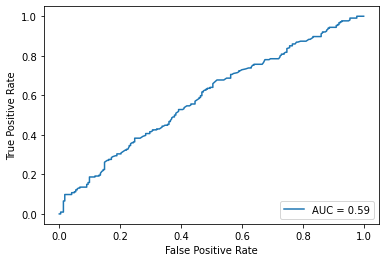

In [ ]:
# roc-кривая
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [ ]:
precision = tpr / (tpr + fpr)

f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

thred_optim = thresholds[5:][np.argmax(f1[5:])]

print("optimal threshold: " + str(thred_optim))

optimal threshold: 0.0830842797369994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
auc_k = auc(fpr, tpr)
print("AUROC:" + str(auc_k))

AUROC:0.5913951334512082


$~$

# Образцы кода, можно не смотреть

### Подготовка данных

In [ ]:
# Конвертация smiles в набор признаков и создание датасета NumpyDataset.
# Для каждого узла (атома) получаем в 30 признаков, и 11 признаков для каждого ребра.
# https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#molgraphconvfeaturizer

featurizer = dc.feat.MolGraphConvFeaturizer()

smiles = davis_train['SMILES']
X = featurizer.featurize(smiles)
y = davis_train['Label']

dataset = dc.data.NumpyDataset(X=X, y=y)

In [ ]:
dataset

<NumpyDataset X.shape: (2086,), y.shape: (2086,), w.shape: (2086,), task_names: [0]>

In [ ]:
smiles_test = davis_test['SMILES']
X_test = featurizer.featurize(smiles_test)
y_test = davis_test['Label']

dataset_test = dc.data.NumpyDataset(X=X_test, y=y_test)

In [ ]:
dataset_test

<NumpyDataset X.shape: (6011,), y.shape: (6011,), w.shape: (6011,), task_names: [0]>

In [ ]:
# разделение выборки на тренировочную и тестовую части (без валидации)

# splitter = dc.splits.RandomSplitter()
# train_dataset, test_dataset = splitter.train_test_split(dataset=dataset, frac_train=0.9)

### Обучение модели

In [ ]:
# обучаем коробочную модель

losses = []

model = GCNModel(mode='classification', n_classes=2,
                 n_tasks=1,
                 batch_size=64, learning_rate=0.001)

loss = model.fit(dataset, nb_epoch=20, all_losses = losses)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
losses

[0.6131621551513672,
 0.5766540908813477,
 0.5641211318969727,
 0.5576749801635742,
 0.5571578979492188,
 0.5536133575439454,
 0.553451410929362]

In [ ]:
# параметры модели

# model._pytorch_optimizer

### Оценка модели

In [ ]:
# Получение предсказаний

y_proba = model.predict(dataset_test)
y_pred = np.argmax(y_proba, axis=1)  # модель выдаёт предсказания как вероятность отнесения к каждому классу
y_true = dataset_test.y.tolist()

In [ ]:
y_proba

array([[0.8203111 , 0.17968886],
       [0.37350973, 0.62649024],
       [0.68542886, 0.31457114],
       ...,
       [0.6053793 , 0.39462075],
       [0.6782785 , 0.32172152],
       [0.3715299 , 0.62847006]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


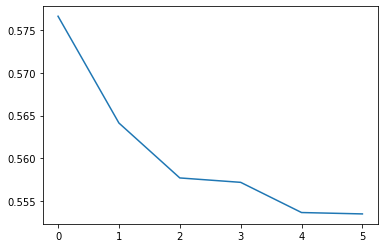

In [ ]:
# Визуализируем изменение loss'а (отрезали первое большое значение)

loss_indices = [i for i,l in enumerate(losses[1:])] 
plt = sns.lineplot(loss_indices, losses[1:])
plt

In [ ]:
# результаты предсказания занесём в датасет

data_results = pd.DataFrame() 
data_results["y_real"] = y_true
data_results["y_pred"] = y_pred

In [ ]:
# Визуализируем полученные результаты

# plt = sns.scatterplot(data=data_results, x="y_real", y="y_pred")
# plt.set(xlim=(-7, 2))
# plt.set(ylim=(-7, 2))
# plt

In [ ]:
# Получим основные метрики для тестовой выборки

# r2_score(y_pred, y_true), mean_squared_error(y_pred, y_true, squared = False)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

In [ ]:
print('Матрица неточностей (правильные прогнозы на главной диагонали):')
print(confusion_matrix(y_true, y_pred))  

# Отчёт о классификации
print('\nОтчёт:')
print(classification_report(y_true, y_pred))

print(f'accuracy = {accuracy_score(y_true, y_pred):.3f}')

Матрица неточностей (правильные прогнозы на главной диагонали):
[[2923 2785]
 [  53  250]]

Отчёт:
              precision    recall  f1-score   support

           0       0.98      0.51      0.67      5708
           1       0.08      0.83      0.15       303

    accuracy                           0.53      6011
   macro avg       0.53      0.67      0.41      6011
weighted avg       0.94      0.53      0.65      6011

accuracy = 0.528


In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, accuracy_score, f1_score

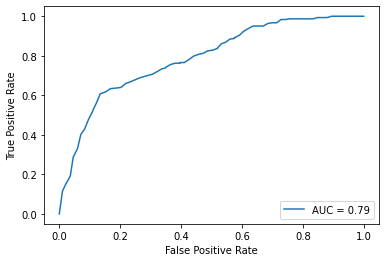

In [ ]:
# для начала посмотрим на roc-кривую
fpr, tpr, thresholds = roc_curve(y_true, y_proba[:,1], )
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [ ]:
precision = tpr / (tpr + fpr)

f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

thred_optim = thresholds[5:][np.argmax(f1[5:])]

print("optimal threshold: " + str(thred_optim))

optimal threshold: 0.35503325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
auc_k = auc(fpr, tpr)
print("AUROC:" + str(auc_k))

AUROC:0.7887881289880916
